In [1]:
# =============================================================================
# Imports
# =============================================================================
import pathlib
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadstat

# Scikit-learn and related ML/Stats libraries
from sklearn.experimental import enable_iterative_imputer  # noqa: F401 # Enable experimental feature
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
from sklearn.manifold import TSNE
import umap
from sklearn.linear_model import LogisticRegression  # binary learner for potential imputation
from mord import LogisticIT # ordered‑logit for potential imputation

# Filter future warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# =============================================================================
# Configuration / Constants
# =============================================================================
SAV_FILE_PATH = './data/WVS_Cross-National_Wave_7_inverted_sav_v6_0.sav'
SELECTED_VARS_CSV_PATH = './data/selected_vars.csv'
COUNTRY_COLUMN = 'B_COUNTRY_ALPHA' # Standardize the country column name

# Define demographic columns to always include
DEMOGRAPHIC_COLUMNS = [
    COUNTRY_COLUMN,
    # 'S018', # Weights (Commented out as in original)
    'H_URBRURAL',
    # 'Q273', #(Commented out as in original)
    'Q260',
    'X003R2',
    'Q275R',
    # 'Q279', #(Commented out as in original)
]

In [3]:
# Configuration for manual imputations based on external research/assumptions
# Structure: {'countries': [list_of_codes], 'column': 'col_name', 'value': imputation_value}
MANUAL_IMPUTATIONS = [
    {'countries': ["UZB", "EGY", "TJK"], 'column': "Q182", 'value': 1},
    {'countries': ["GBR", "NIR"], 'column': "Q151P", 'value': 0},
    {'countries': ["GBR", "NIR"], 'column': "Q189", 'value': 1},
    {'countries': ["EGY"], 'column': "Q65P", 'value': 4},
    {'countries': ["EGY", "IRQ"], 'column': "Q186", 'value': 1},
    {'countries': ["EGY", "IRQ"], 'column': "Q165P", 'value': 1},
    {'countries': ["EGY", "TUR"], 'column': "Q245", 'value': 1},
    {'countries': ["TUR"], 'column': "Q237P", 'value': 1},
    {'countries': ["EGY"], 'column': "Q237P", 'value': 4}, # Note: EGY gets Q237P set twice, last one takes precedence
    {'countries': ["KGZ", "IRQ"], 'column': "Q166P", 'value': 1},
    {'countries': ["IRN", "TJK"], 'column': "Q22P", 'value': 1},
    {'countries': ["NLD"], 'column': "Q259P", 'value': 3},
    {'countries': ["SGP"], 'column': "Q255P", 'value': 4},
    {'countries': ["CHN"], 'column': "Q90", 'value': 1},
    {'countries': ["CHN"], 'column': "Q234P", 'value': 2},
    {'countries': ["CHN"], 'column': "Q130P", 'value': 2},
    {'countries': ["EGY"], 'column': "Q170P", 'value': 4},
    {'countries': ["EGY"], 'column': "Q197P", 'value': 3},
    {'countries': ["EGY"], 'column': "Q25P", 'value': 1},
    {'countries': ["EGY"], 'column': "Q69P", 'value': 3},
    {'countries': ["EGY"], 'column': "Q70P", 'value': 3},
    {'countries': ["EGY"], 'column': "Q71P", 'value': 3},
    {'countries': ["VEN"], 'column': "Q160", 'value': 4},
    {'countries': ["VEN"], 'column': "Q162", 'value': 3},
    {'countries': ["VEN"], 'column': "Q163", 'value': 8},
    {'countries': ["IRQ"], 'column': "Q164", 'value': 10},
]

In [4]:
MISSING_THRESHOLD_OVERALL = 10 # Percentage threshold for reporting overall missing columns
MISSING_THRESHOLDS_WITHIN_COUNTRY = [25, 50, 75, 100] # Percentage thresholds for within-country analysis
HEATMAP_CHUNK_SIZE = 20 # Number of columns per heatmap chunk

In [5]:
# =============================================================================
# Function Definitions
# =============================================================================

def load_data(sav_path: str) -> tuple[pd.DataFrame, object]:
    """Loads data and metadata from a .sav file."""
    print(f"Loading data from: {sav_path}")
    df, meta = pyreadstat.read_sav(sav_path)
    print(f"Loaded DataFrame shape: {df.shape}")
    return df, meta

def load_selected_variables(csv_path: str) -> pd.DataFrame:
    """Loads the list of selected variables from a CSV file."""
    print(f"Loading selected variables from: {csv_path}")
    selected_vars_df = pd.read_csv(csv_path)
    print(f"Loaded {len(selected_vars_df)} variable definitions.")
    return selected_vars_df

def select_data_columns(df: pd.DataFrame, selected_vars_df: pd.DataFrame,
                       demographic_cols: list[str]) -> pd.DataFrame:
    """Selects the final set of columns based on the selected variables and demographics."""
    print("Selecting relevant data columns...")
    # Get survey variables marked as 'Yes'
    survey_columns = selected_vars_df.loc[selected_vars_df['Selected'] == 'Yes', 'Variable_Code'].tolist()
    print(f"Found {len(survey_columns)} selected survey variables.")

    # Combine demographic and survey columns
    final_columns = demographic_cols + survey_columns
    print(f"Total columns selected (demographic + survey): {len(final_columns)}")

    # Ensure all selected columns exist in the original dataframe
    missing_in_df = [col for col in final_columns if col not in df.columns]
    if missing_in_df:
        print(f"Warning: The following selected columns were not found in the main DataFrame: {missing_in_df}")
        # Filter out columns that don't exist
        final_columns = [col for col in final_columns if col in df.columns]
        print(f"Proceeding with {len(final_columns)} found columns.")

    df_selected = df[final_columns].copy() # Use copy to avoid SettingWithCopyWarning later
    print(f"Selected DataFrame shape: {df_selected.shape}")
    print("Selected DataFrame head:")
    print(df_selected.head())
    return df_selected

def analyze_overall_missing(df: pd.DataFrame, threshold: float) -> list[str]:
    """Identifies columns with overall missing percentage above a threshold."""
    print(f"\nAnalyzing overall missing data (threshold > {threshold}%)...")
    missing_percentage = df.isnull().mean() * 100
    columns_with_high_missing = missing_percentage[missing_percentage > threshold].index.tolist()
    print(f"Found {len(columns_with_high_missing)} columns missing more than {threshold}% data overall.")
    if columns_with_high_missing:
        print(f"Columns: {columns_with_high_missing}")
    return columns_with_high_missing

def analyze_fully_missing_by_country(data: pd.DataFrame, country_col: str, selected_vars_df: pd.DataFrame) -> tuple[list[str], pd.DataFrame]:
    """
    Analyzes which columns are 100% missing within specific countries.
    Also merges with question text for context.
    """
    print(f"\nAnalyzing columns fully missing within specific countries (using column '{country_col}')...")
    country_list = data[country_col].unique().tolist()
    missing_data_by_country = {}
    columns_with_all_missing_count = {} # {col: [country1, country2], ...}

    for country_code in country_list:
        country_data = data[data[country_col] == country_code]
        if country_data.empty:
            print(f"Warning: No data found for country code: {country_code}")
            continue

        percent_missing = country_data.drop(columns=[country_col]).isnull().mean() * 100
        all_missing_cols = percent_missing[percent_missing == 100].index.tolist()

        missing_data_by_country[country_code] = {
            'total_rows': len(country_data),
            'all_missing_columns': all_missing_cols,
            'percent_missing': percent_missing # Store full percentages if needed later
        }

        for col in all_missing_cols:
            columns_with_all_missing_count.setdefault(col, []).append(country_code)

    if not country_list:
         print("Error: No countries found to analyze.")
         return [], pd.DataFrame()

    num_countries = len(country_list)
    columns_missing_by_frequency = pd.DataFrame({
        'Column': list(columns_with_all_missing_count.keys()),
        'Number of Countries': [len(countries) for countries in columns_with_all_missing_count.values()],
        'Percentage of Countries': [len(countries) / num_countries * 100 for countries in columns_with_all_missing_count.values()],
        'Countries': [', '.join(countries) for countries in columns_with_all_missing_count.values()]
    }).sort_values('Number of Countries', ascending=False).reset_index(drop=True)

    columns_always_missing = [col for col, countries in columns_with_all_missing_count.items()
                              if len(countries) == num_countries]

    print(f"Analysis completed for {num_countries} countries.")
    print(f"Found {len(columns_with_all_missing_count)} columns with 100% missing values in at least one country.")

    if columns_always_missing:
        print(f"\nColumns with 100% missing values in ALL countries ({len(columns_always_missing)}):")
        for col in columns_always_missing:
            print(f"- {col}")

    # Merge with Question Text for context
    if not columns_missing_by_frequency.empty:
        print("\nTop columns with most frequent 100% missing values across countries (with Question Text):")
        merged_missing_info = columns_missing_by_frequency.merge(
            selected_vars_df[['Variable_Code', 'Question_Text']],
            left_on='Column',
            right_on='Variable_Code',
            how='left'
        )
        # Select and reorder columns for display
        display_cols = ['Column', 'Question_Text', 'Number of Countries', 'Percentage of Countries', 'Countries']
        # Handle cases where Question_Text might not be found (e.g., demographic columns)
        if 'Variable_Code' in merged_missing_info.columns:
             merged_missing_info = merged_missing_info[display_cols]
        print(merged_missing_info.head(50)) # Display top 50 or fewer
    else:
        print("\nNo columns found with 100% missing data in any single country.")
        merged_missing_info = pd.DataFrame(columns=['Column', 'Question_Text', 'Number of Countries', 'Percentage of Countries', 'Countries'])


    return columns_always_missing, merged_missing_info


def apply_manual_imputations(data: pd.DataFrame, imputations: list[dict], country_col: str) -> pd.DataFrame:
    """Applies a list of predefined manual imputations to the DataFrame."""
    print("\nApplying manual imputations based on predefined rules...")
    updated_data = data.copy() # Work on a copy
    total_rows_affected = 0

    for imp_rule in imputations:
        countries = imp_rule['countries']
        column = imp_rule['column']
        value = imp_rule['value']

        if column not in updated_data.columns:
            print(f"Warning: Column '{column}' for imputation not found in the DataFrame. Skipping rule: {imp_rule}")
            continue

        # Convert single country code to list if necessary
        if isinstance(countries, str):
            countries = [countries]

        mask = updated_data[country_col].isin(countries)
        num_updated = mask.sum()

        if num_updated > 0:
            # Optional: Verify if the data was actually missing before update (as in original function)
            # was_missing = updated_data.loc[mask, column].isnull().all() # Check if all targeted cells were NaN
            # print(f"Updating {column} to {value} for {num_updated} rows in {countries}. Data was previously missing: {was_missing}")
            updated_data.loc[mask, column] = value
            total_rows_affected += num_updated
            # Simple print statement:
            print(f"- Updated '{column}' to '{value}' for {num_updated} rows in countries: {countries}")
        else:
            print(f"- No rows found for countries {countries} to update column '{column}'.")

    print(f"Manual imputations applied. Total rows affected across all rules: {total_rows_affected}")
    return updated_data

def analyze_within_country_missing(data: pd.DataFrame, country_col: str, thresholds: list[int]) -> pd.DataFrame:
    """Analyzes missing data percentages within each country for different thresholds."""
    print(f"\nAnalyzing missing data within each country for thresholds: {thresholds}%...")

    # Calculate missing data percentage by country and column
    missing_by_country = data.groupby(country_col).apply(
        lambda x: x.drop(country_col, axis=1).isnull().mean() * 100
    )

    # Identify columns meeting thresholds for each country
    country_missing_analysis = {}
    for country in missing_by_country.index:
        country_data = missing_by_country.loc[country]
        country_analysis = {f"≥{t}%_missing": country_data[country_data >= t].index.tolist() for t in thresholds}
        country_missing_analysis[country] = country_analysis

    # Create a summary table
    summary_data = []
    for country, analysis in country_missing_analysis.items():
        row = {'Country': country}
        row.update({f"≥{t}%_missing": len(analysis[f"≥{t}%_missing"]) for t in thresholds})
        summary_data.append(row)

    summary_df = pd.DataFrame(summary_data).set_index('Country')
    # Sort by the highest threshold count (e.g., 100%) descending
    summary_df = summary_df.sort_values(by=f"≥{thresholds[-1]}%_missing", ascending=False)

    print("\n=== Summary of Columns with Missing Data by Country (%) ===")
    print(summary_df)

    # Return the detailed breakdown by country/column for plotting
    return summary_df, missing_by_country


def visualize_missing_data_summary(summary_df: pd.DataFrame, filename: str = 'missing_data_summary_by_country.png'):
    """Generates a heatmap summarizing missing column counts per country."""
    print("\nGenerating summary heatmap of missing data counts...")
    plt.figure(figsize=(12, max(6, len(summary_df) * 0.3))) # Adjust height based on number of countries
    sns.heatmap(summary_df, cmap='YlOrRd', annot=True, fmt='d', linewidths=0.5)
    plt.title('Number of Columns with ≥ Threshold % Missing Data by Country')
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved summary heatmap to: {filename}")
    plt.show()


def visualize_missing_data_details(missing_by_country_df: pd.DataFrame, chunk_size: int, base_filename: str = 'missing_data_heatmap_part_'):
    """Generates detailed heatmaps of missing percentages in chunks."""
    print(f"\nGenerating detailed heatmaps of missing percentages (chunk size: {chunk_size})...")
    num_cols = missing_by_country_df.shape[1]
    num_countries = missing_by_country_df.shape[0]

    for i in range(0, num_cols, chunk_size):
        end = min(i + chunk_size, num_cols)
        chunk_data = missing_by_country_df.iloc[:, i:end]
        part_num = i // chunk_size + 1
        filename = f"{base_filename}{part_num}.png"

        plt.figure(figsize=(min(25, chunk_data.shape[1] * 0.8), max(8, num_countries * 0.25))) # Adjust size dynamically
        sns.heatmap(chunk_data, cmap='YlOrRd', vmin=0, vmax=100,
                    linewidths=0.5, linecolor='lightgray', cbar_kws={'label': '% Missing Data'})
        plt.title(f'Percentage of Missing Data by Country (Columns {i+1}-{end})')
        plt.ylabel('Country Code')
        plt.xlabel('Survey Questions/Columns')
        plt.xticks(rotation=90, fontsize=8)
        plt.yticks(rotation=0, fontsize=8)
        plt.tight_layout()
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved detailed heatmap chunk {part_num} to: {filename}")
        plt.show()



In [6]:
# =============================================================================
# Main Execution Workflow
# =============================================================================

def main():
    """Main function to orchestrate the data loading, analysis, and imputation."""
    print("--- Starting WVS Data Processing ---")

    # 1. Load Data
    df_raw, meta = load_data(SAV_FILE_PATH)
    selected_vars_df = load_selected_variables(SELECTED_VARS_CSV_PATH)

    # 2. Select Columns
    df_selected = select_data_columns(df_raw, selected_vars_df, DEMOGRAPHIC_COLUMNS)

    # 3. Initial Missing Data Analysis (Overall)
    _ = analyze_overall_missing(df_selected, MISSING_THRESHOLD_OVERALL)

    # 4. Analyze Fully Missing Columns by Country
    _, missing_freq_info = analyze_fully_missing_by_country(df_selected, COUNTRY_COLUMN, selected_vars_df)

    # 5. Apply Manual Imputations/Proxy Values
    df_updated = apply_manual_imputations(df_selected, MANUAL_IMPUTATIONS, COUNTRY_COLUMN)

    # 6. Re-analyze Fully Missing Columns by Country (after manual imputation)
    print("\n--- Re-analyzing fully missing columns after manual imputation ---")
    always_missing_after, missing_freq_after = analyze_fully_missing_by_country(df_updated, COUNTRY_COLUMN, selected_vars_df)
    # Note: We expect fewer (or different) columns here compared to step 4.
    # If 'always_missing_after' still has columns, they might need removal or different handling.
    if always_missing_after:
         print(f"\nWarning: Columns still 100% missing in all countries after manual imputation: {always_missing_after}")
         # Consider dropping these columns:
         # df_updated = df_updated.drop(columns=always_missing_after)
         # print(f"Dropped {len(always_missing_after)} columns that were missing everywhere.")

    # 7. Analyze Missing Data Within Countries (Thresholds)
    summary_df, missing_by_country_details = analyze_within_country_missing(df_updated, COUNTRY_COLUMN, MISSING_THRESHOLDS_WITHIN_COUNTRY)

    # 8. Visualize Missing Data
    visualize_missing_data_summary(summary_df)
    visualize_missing_data_details(missing_by_country_details, HEATMAP_CHUNK_SIZE)

    # 9. Prepare for Next Stage (Imputation)
    print("\n--- Data pre-processing and initial missing data analysis complete ---")
    print(f"Shape of data ready for imputation: {df_updated.shape}")
    print("Next steps would typically involve imputation strategies (e.g., IterativeImputer, SimpleImputer).")
    # The `df_updated` DataFrame is the result of this script's preprocessing.

    # Save the df_updated DataFrame to a CSV for further analysis or imputation with utf-8 encoding
    df_updated.to_csv('./data/wvs_wave7_preprocessed.csv', index=False, encoding='utf-8')

    # Example: Show info for the final dataframe
    print("\nFinal DataFrame info:")
    df_updated.info()

--- Starting WVS Data Processing ---
Loading data from: ./data/WVS_Cross-National_Wave_7_inverted_sav_v6_0.sav
Loaded DataFrame shape: (97220, 611)
Loading selected variables from: ./data/selected_vars.csv
Loaded 227 variable definitions.
Selecting relevant data columns...
Found 97 selected survey variables.
Total columns selected (demographic + survey): 102
Selected DataFrame shape: (97220, 102)
Selected DataFrame head:
  B_COUNTRY_ALPHA  H_URBRURAL  Q260  X003R2  Q275R  Q106  Q107  Q108  Q109  \
0             CYP         1.0   1.0     3.0    1.0   1.0   5.0   1.0   5.0   
1             CYP         1.0   2.0     3.0    1.0   5.0  10.0   1.0   5.0   
2             CYP         1.0   2.0     2.0    2.0   5.0   5.0   1.0   5.0   
3             CYP         1.0   2.0     3.0    2.0   1.0   5.0   5.0   5.0   
4             CYP         1.0   2.0     3.0    2.0   1.0   5.0   1.0  10.0   

   Q110  ...  Q69P  Q6P  Q70P  Q71P  Q72P  Q73P  Q77P  Q8P  Q90  Q9P  
0  10.0  ...   1.0  4.0   1.0   1.0

C:\Users\singh\AppData\Local\Temp\ipykernel_7480\4027261639.py:170: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_country = data.groupby(country_col).apply(


Saved summary heatmap to: missing_data_summary_by_country.png


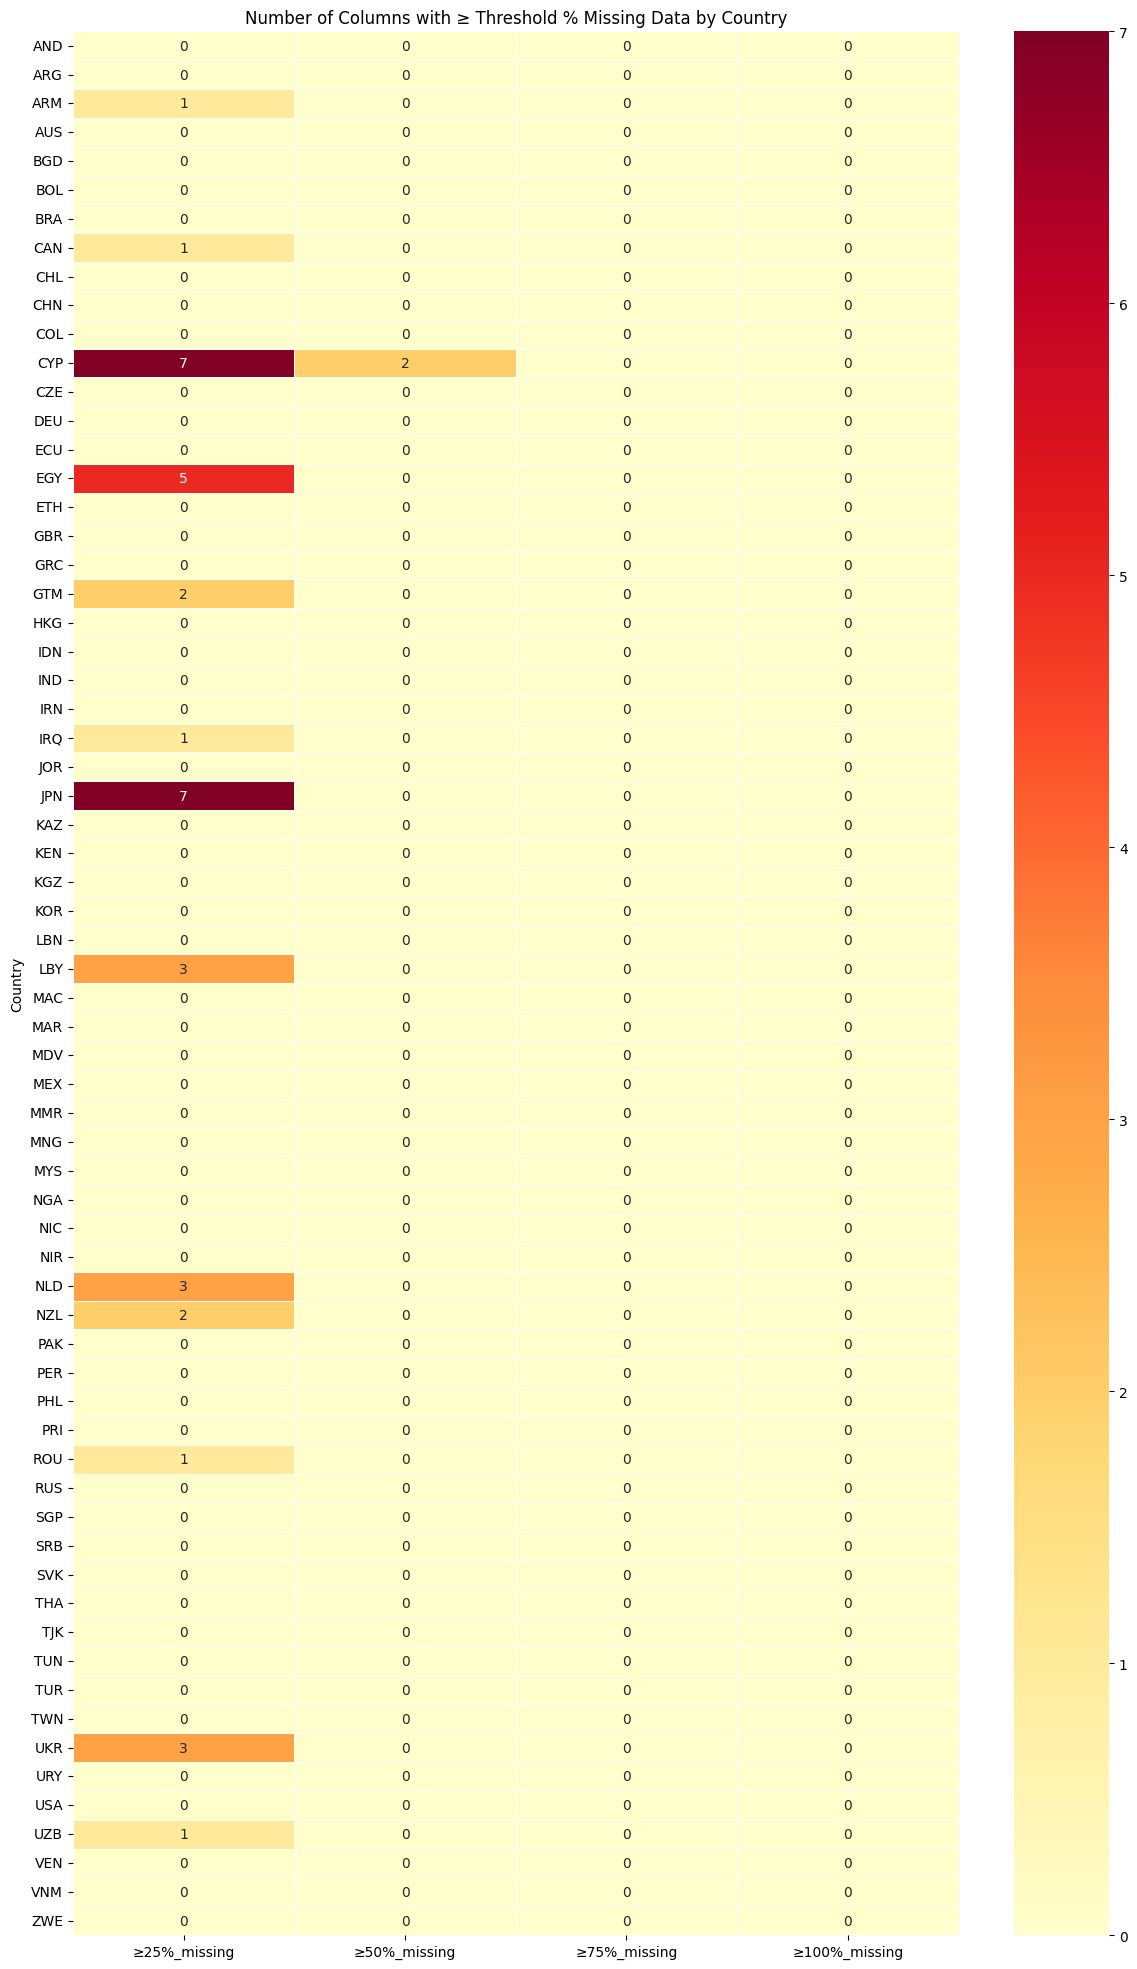


Generating detailed heatmaps of missing percentages (chunk size: 20)...
Saved detailed heatmap chunk 1 to: missing_data_heatmap_part_1.png


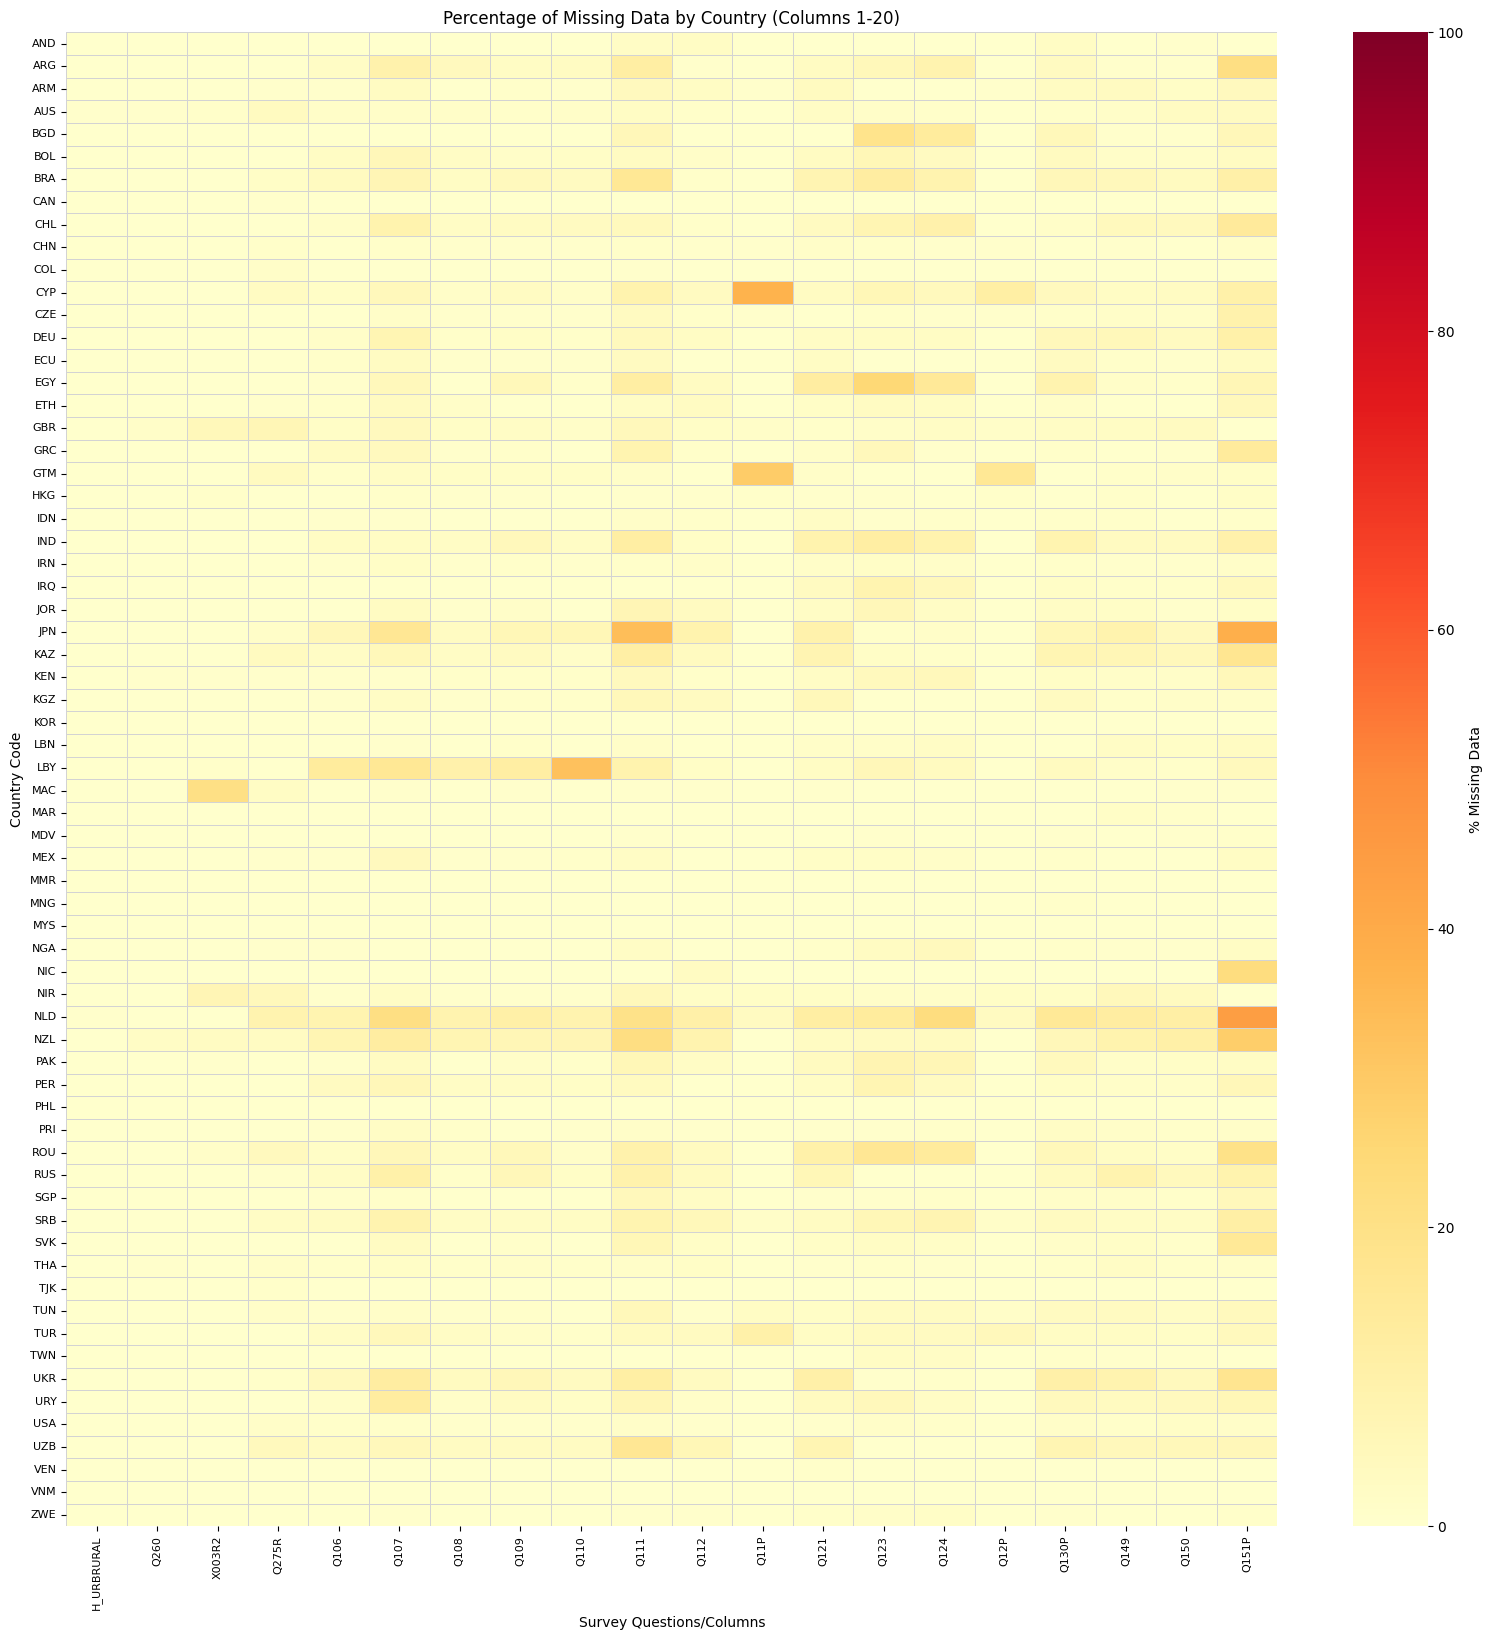

Saved detailed heatmap chunk 2 to: missing_data_heatmap_part_2.png


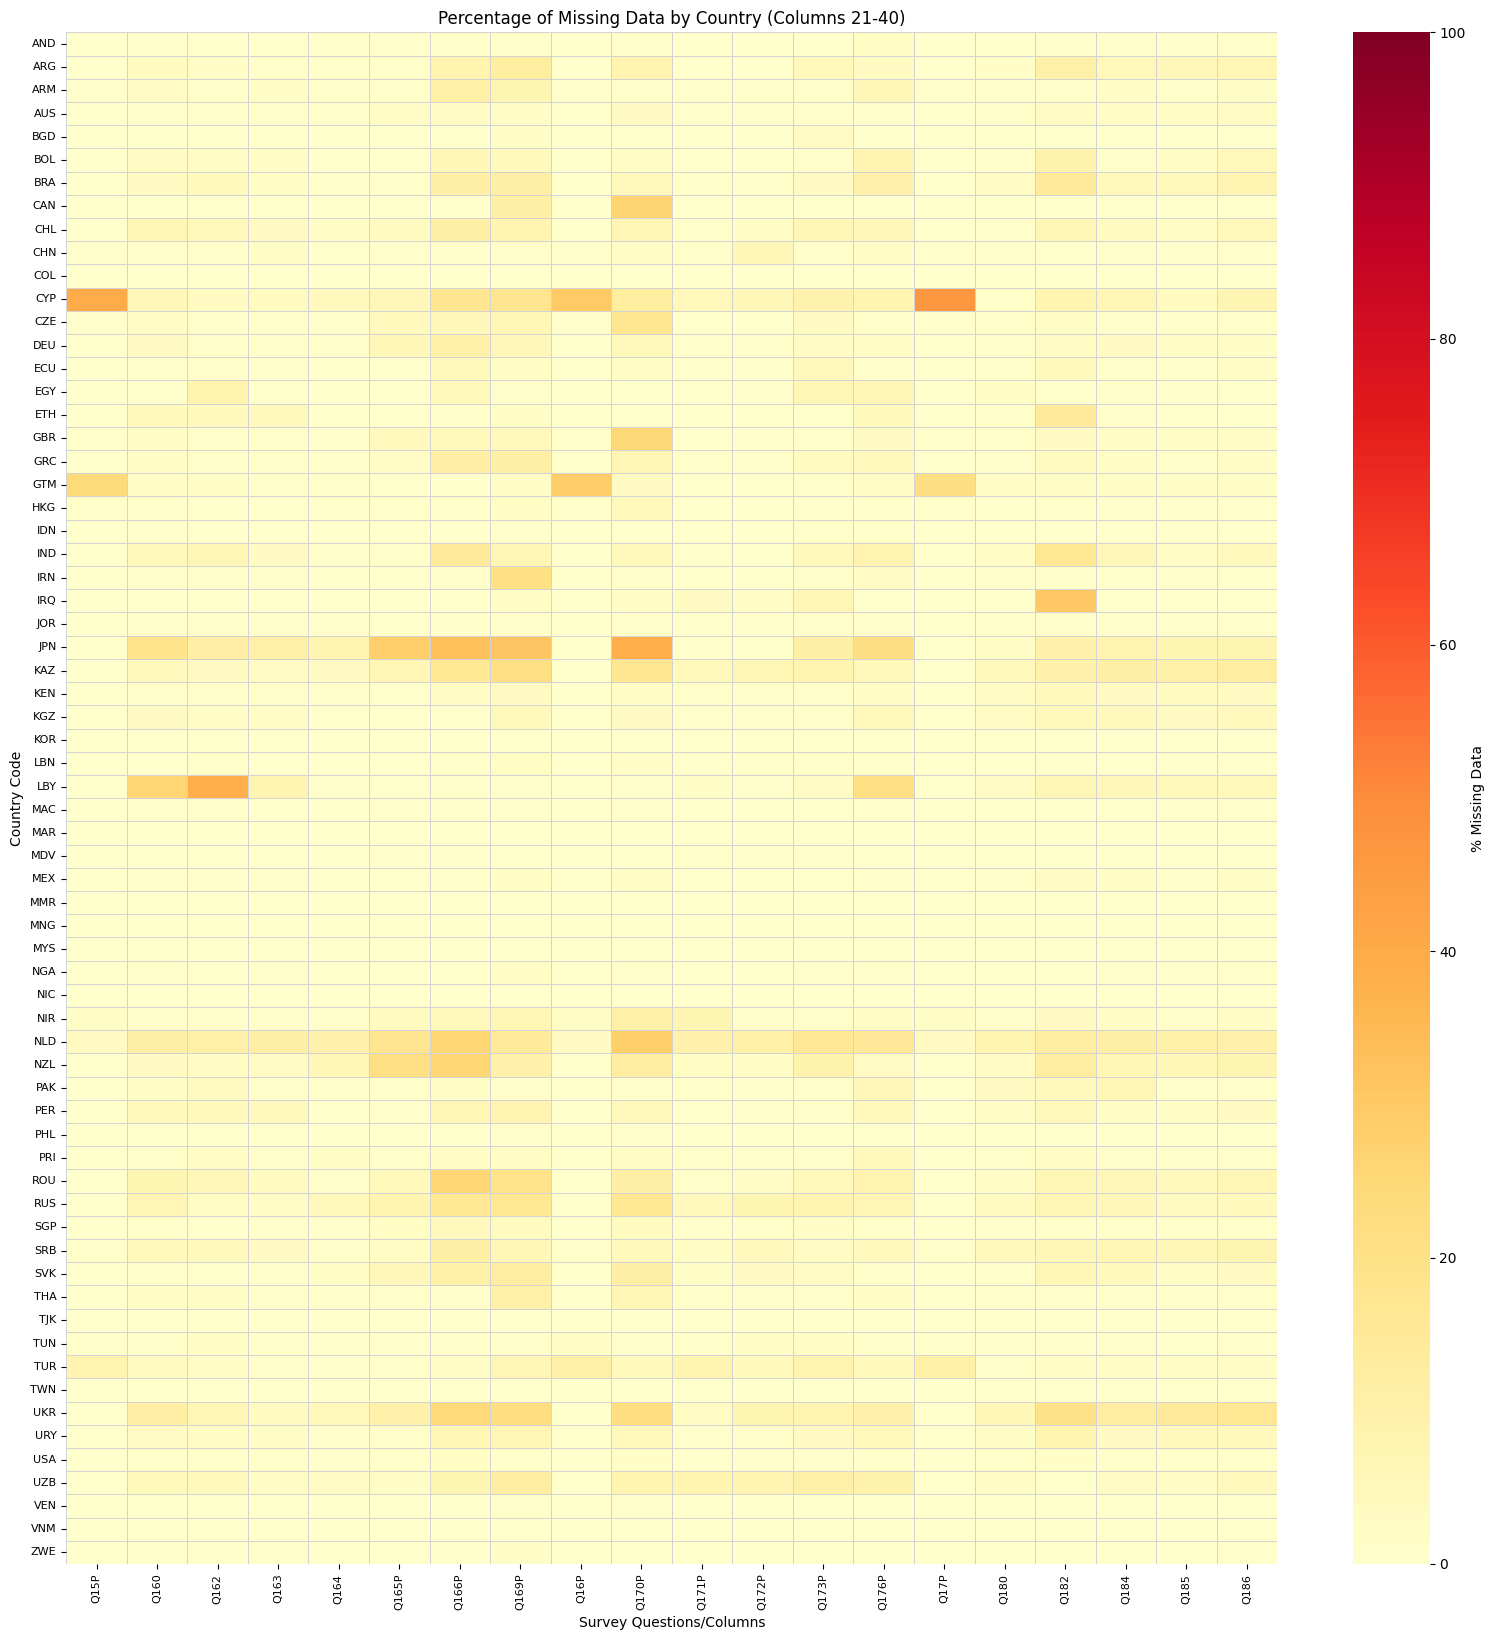

Saved detailed heatmap chunk 3 to: missing_data_heatmap_part_3.png


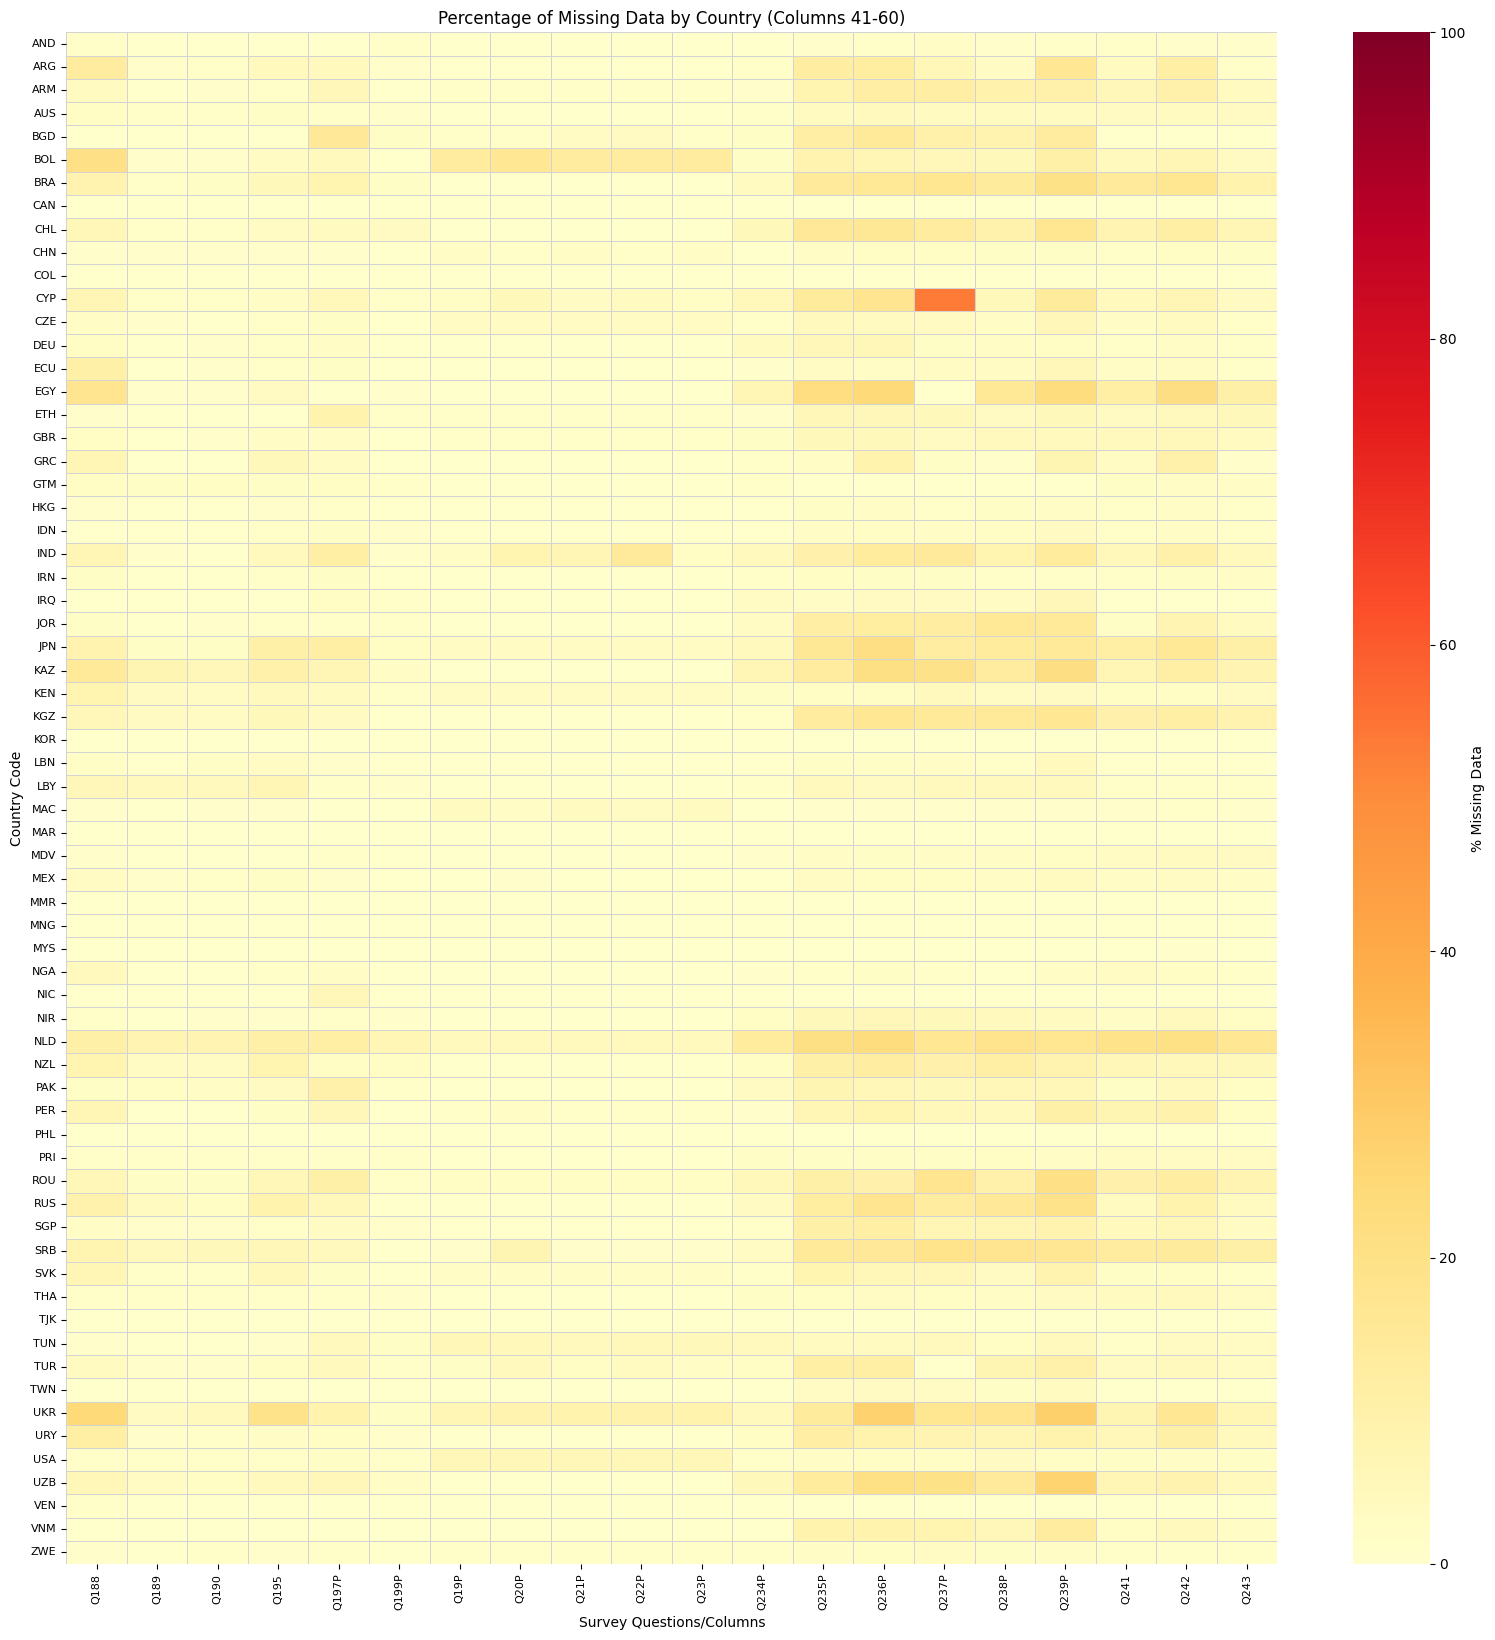

Saved detailed heatmap chunk 4 to: missing_data_heatmap_part_4.png


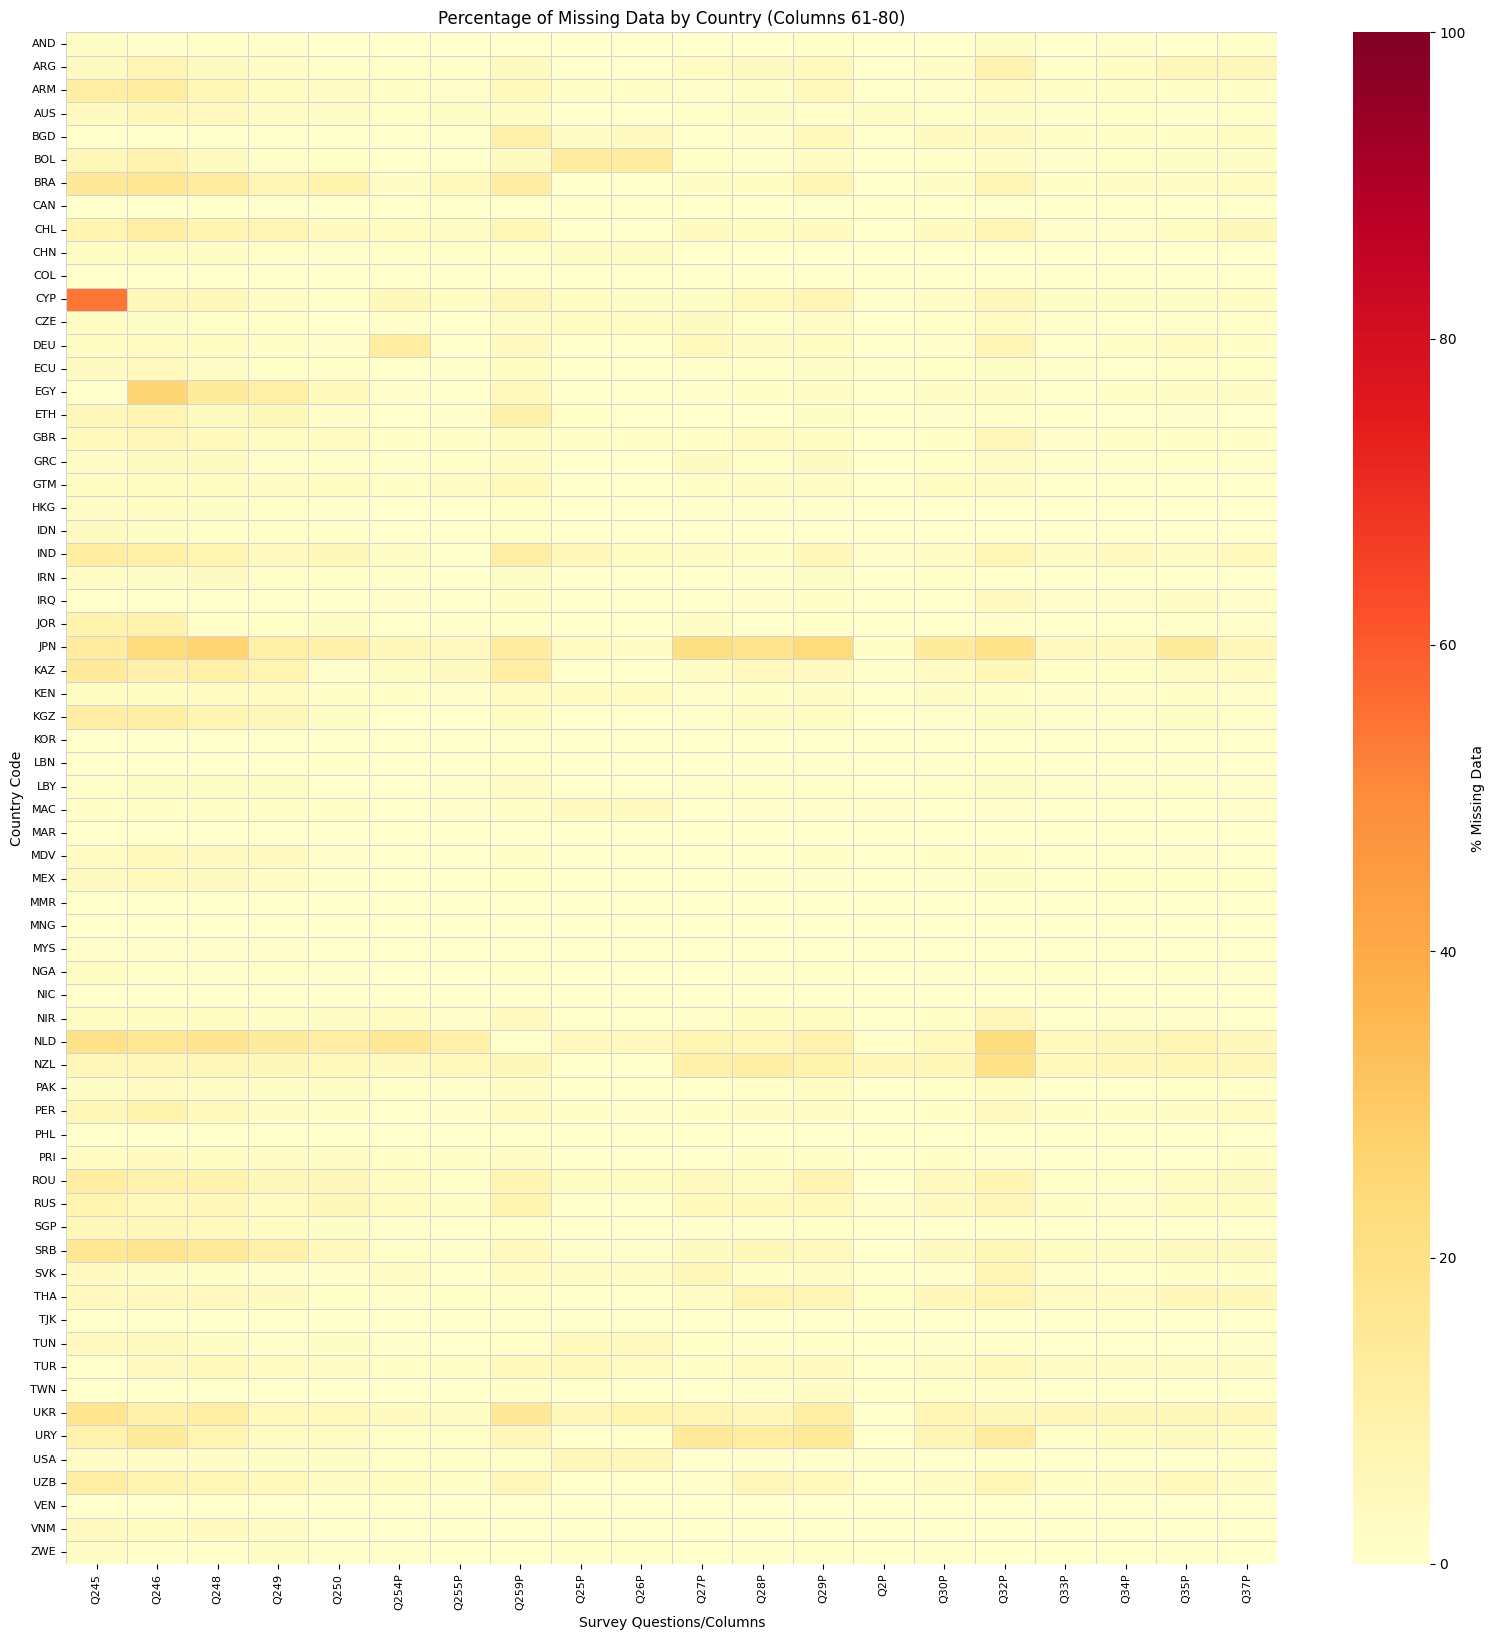

Saved detailed heatmap chunk 5 to: missing_data_heatmap_part_5.png


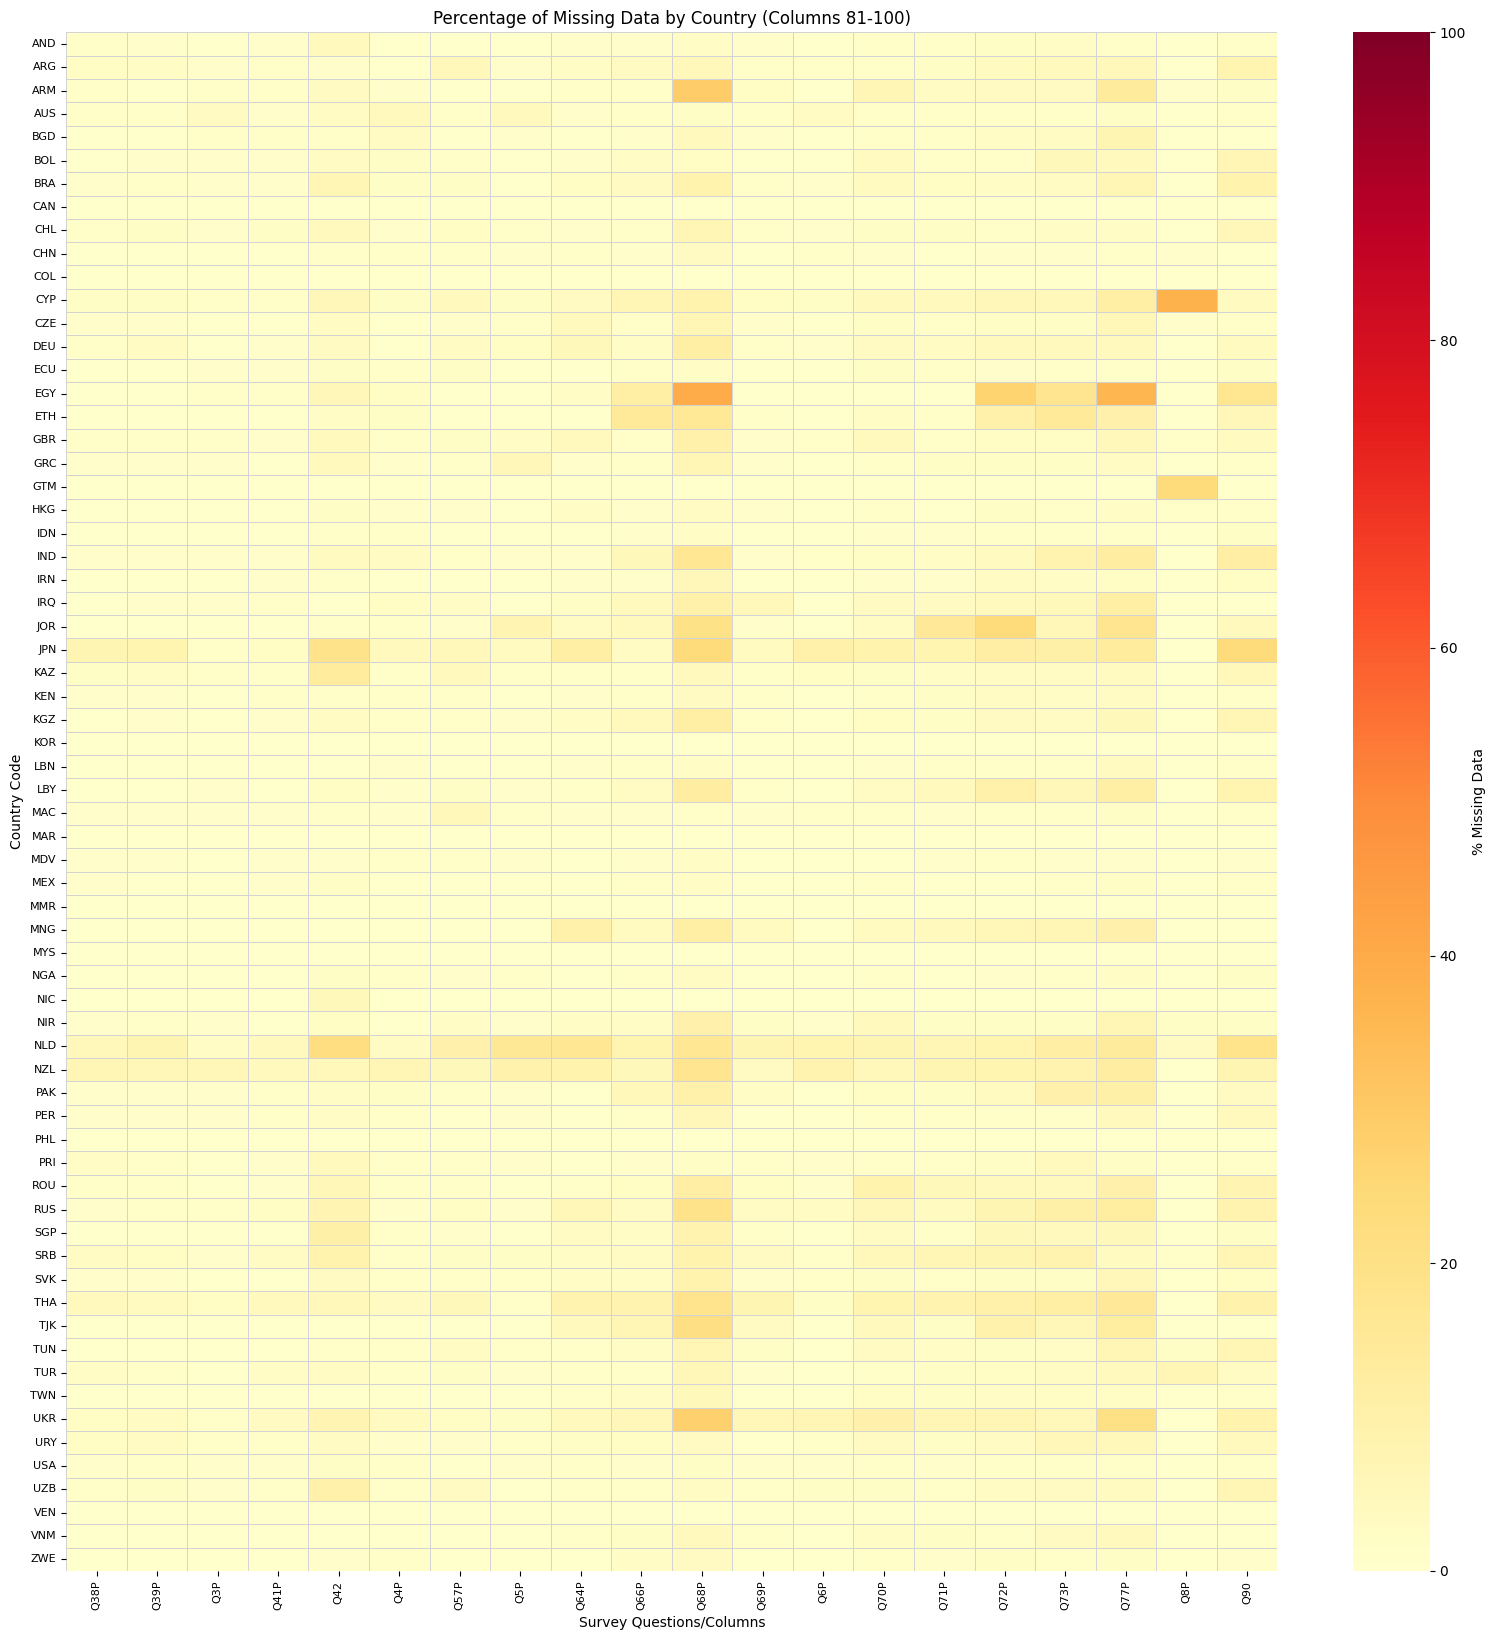

C:\Users\singh\AppData\Local\Temp\ipykernel_7480\4027261639.py:231: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved detailed heatmap chunk 6 to: missing_data_heatmap_part_6.png


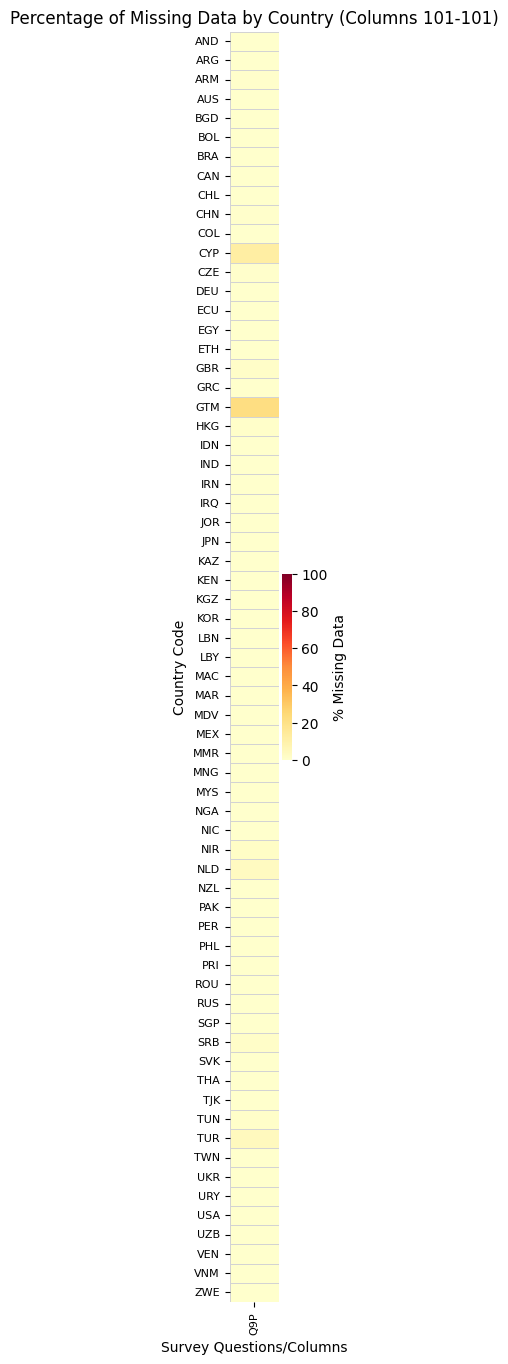


--- Data pre-processing and initial missing data analysis complete ---
Shape of data ready for imputation: (97220, 102)
Next steps would typically involve imputation strategies (e.g., IterativeImputer, SimpleImputer).

Final DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97220 entries, 0 to 97219
Columns: 102 entries, B_COUNTRY_ALPHA to Q9P
dtypes: float64(101), object(1)
memory usage: 75.7+ MB


In [7]:
if __name__ == "__main__":
    main()

# Next Stage: Imputation
- The `df_updated` DataFrame resulting from the `main()` function execution above contains the data after initial selection, manual imputation for specific country/question combinations, and missing data analysis.
- It is now ready for more systematic imputation techniques potentially grouped by country or demographic profiles.

# Output
```python
--- Starting WVS Data Processing ---
Loading data from: ./data/WVS_Cross-National_Wave_7_inverted_sav_v6_0.sav
Loaded DataFrame shape: (97220, 611)
Loading selected variables from: ./data/selected_vars.csv
Loaded 227 variable definitions.
Selecting relevant data columns...
Found 97 selected survey variables.
Total columns selected (demographic + survey): 102
Selected DataFrame shape: (97220, 102)
Selected DataFrame head:
  B_COUNTRY_ALPHA  H_URBRURAL  Q260  X003R2  Q275R  Q106  Q107  Q108  Q109  \
0             CYP         1.0   1.0     3.0    1.0   1.0   5.0   1.0   5.0   
1             CYP         1.0   2.0     3.0    1.0   5.0  10.0   1.0   5.0   
2             CYP         1.0   2.0     2.0    2.0   5.0   5.0   1.0   5.0   
3             CYP         1.0   2.0     3.0    2.0   1.0   5.0   5.0   5.0   
4             CYP         1.0   2.0     3.0    2.0   1.0   5.0   1.0  10.0   

   Q110  ...  Q69P  Q6P  Q70P  Q71P  Q72P  Q73P  Q77P  Q8P  Q90  Q9P  
0  10.0  ...   1.0  4.0   1.0   1.0   1.0   1.0   1.0  1.0  1.0  1.0  
1  10.0  ...   3.0  4.0   3.0   3.0   2.0   2.0   3.0  0.0  NaN  1.0  
2  10.0  ...   3.0  4.0   3.0   3.0   NaN   3.0   3.0  1.0  5.0  1.0  
3   8.0  ...   NaN  4.0   NaN   NaN   1.0   NaN   NaN  0.0  7.0  1.0  
4  10.0  ...   3.0  4.0   NaN   NaN   NaN   NaN   3.0  0.0  1.0  1.0  

[5 rows x 102 columns]

Analyzing overall missing data (threshold > 10%)...
Found 0 columns missing more than 10% data overall.

Analyzing columns fully missing within specific countries (using column 'B_COUNTRY_ALPHA')...
Analysis completed for 66 countries.
Found 24 columns with 100% missing values in at least one country.

Top columns with most frequent 100% missing values across countries (with Question Text):
   Column                                      Question_Text  \
0    Q182                         Justifiable: Homosexuality   
1   Q151P               Willingness to fight for country (+)   
2    Q189            Justifiable: For a man to beat his wife   
3   Q165P                                Believe in: God (+)   
4    Q245  Democracy: The army takes over when government...   
5   Q237P         Political system: Having the army rule (+)   
6   Q166P                   Believe in: life after death (+)   
7    Q22P                         Neighbors: Homosexuals (+)   
8    Q186                   Justifiable: Sex before marriage   
9   Q259P                      How close you feel: World (+)   
10    Q90  International organizations: being effective v...   
11  Q234P  Some people think that having honest elections...   
12  Q130P  People from other countries coming here to wor...   
13  Q255P  How close you feel: Your [village, town or cit...   
14  Q170P    The only acceptable religion is my religion (+)   
15  Q197P  Government has the right: Monitor all e-mails ...   
16   Q25P   Neighbors: Unmarried couples living together (+)   
17   Q69P                         Confidence: The Police (+)   
18   Q70P              Confidence: Justice System/Courts (+)   
19   Q71P                     Confidence: The Government (+)   
20   Q160  We depend too much on science and not enough o...   
21   Q162  It is not important for me to know about scien...   
22   Q163  The world is better off, or worse off, because...   
23   Q164                                  Importance of God   

    Number of Countries  Percentage of Countries      Countries  
0                     3                 4.545455  UZB, EGY, TJK  
1                     2                 3.030303       GBR, NIR  
2                     2                 3.030303       GBR, NIR  
3                     2                 3.030303       EGY, IRQ  
4                     2                 3.030303       TUR, EGY  
5                     2                 3.030303       TUR, EGY  
6                     2                 3.030303       KGZ, IRQ  
7                     2                 3.030303       IRN, TJK  
8                     2                 3.030303       EGY, IRQ  
9                     1                 1.515152            NLD  
10                    1                 1.515152            CHN  
11                    1                 1.515152            CHN  
12                    1                 1.515152            CHN  
13                    1                 1.515152            SGP  
14                    1                 1.515152            EGY  
15                    1                 1.515152            EGY  
16                    1                 1.515152            EGY  
17                    1                 1.515152            EGY  
18                    1                 1.515152            EGY  
19                    1                 1.515152            EGY  
20                    1                 1.515152            VEN  
21                    1                 1.515152            VEN  
22                    1                 1.515152            VEN  
23                    1                 1.515152            IRQ  

Applying manual imputations based on predefined rules...
- Updated 'Q182' to '1' for 3650 rows in countries: ['UZB', 'EGY', 'TJK']
- Updated 'Q151P' to '0' for 3056 rows in countries: ['GBR', 'NIR']
- Updated 'Q189' to '1' for 3056 rows in countries: ['GBR', 'NIR']
Warning: Column 'Q65P' for imputation not found in the DataFrame. Skipping rule: {'countries': ['EGY'], 'column': 'Q65P', 'value': 4}
- Updated 'Q186' to '1' for 2400 rows in countries: ['EGY', 'IRQ']
- Updated 'Q165P' to '1' for 2400 rows in countries: ['EGY', 'IRQ']
- Updated 'Q245' to '1' for 3615 rows in countries: ['EGY', 'TUR']
- Updated 'Q237P' to '1' for 2415 rows in countries: ['TUR']
- Updated 'Q237P' to '4' for 1200 rows in countries: ['EGY']
- Updated 'Q166P' to '1' for 2400 rows in countries: ['KGZ', 'IRQ']
- Updated 'Q22P' to '1' for 2699 rows in countries: ['IRN', 'TJK']
- Updated 'Q259P' to '3' for 2145 rows in countries: ['NLD']
- Updated 'Q255P' to '4' for 2012 rows in countries: ['SGP']
- Updated 'Q90' to '1' for 3036 rows in countries: ['CHN']
- Updated 'Q234P' to '2' for 3036 rows in countries: ['CHN']
- Updated 'Q130P' to '2' for 3036 rows in countries: ['CHN']
- Updated 'Q170P' to '4' for 1200 rows in countries: ['EGY']
- Updated 'Q197P' to '3' for 1200 rows in countries: ['EGY']
- Updated 'Q25P' to '1' for 1200 rows in countries: ['EGY']
- Updated 'Q69P' to '3' for 1200 rows in countries: ['EGY']
- Updated 'Q70P' to '3' for 1200 rows in countries: ['EGY']
- Updated 'Q71P' to '3' for 1200 rows in countries: ['EGY']
- Updated 'Q160' to '4' for 1190 rows in countries: ['VEN']
- Updated 'Q162' to '3' for 1190 rows in countries: ['VEN']
- Updated 'Q163' to '8' for 1190 rows in countries: ['VEN']
- Updated 'Q164' to '10' for 1200 rows in countries: ['IRQ']
Manual imputations applied. Total rows affected across all rules: 52126

--- Re-analyzing fully missing columns after manual imputation ---

Analyzing columns fully missing within specific countries (using column 'B_COUNTRY_ALPHA')...
Analysis completed for 66 countries.
Found 0 columns with 100% missing values in at least one country.

No columns found with 100% missing data in any single country.

Analyzing missing data within each country for thresholds: [25, 50, 75, 100]%...

=== Summary of Columns with Missing Data by Country (%) ===
         ≥25%_missing  ≥50%_missing  ≥75%_missing  ≥100%_missing
Country                                                         
AND                 0             0             0              0
ARG                 0             0             0              0
ARM                 1             0             0              0
AUS                 0             0             0              0
BGD                 0             0             0              0
...               ...           ...           ...            ...
USA                 0             0             0              0
UZB                 1             0             0              0
VEN                 0             0             0              0
VNM                 0             0             0              0
ZWE                 0             0             0              0

[66 rows x 4 columns]

Generating summary heatmap of missing data counts...
C:\Users\singh\AppData\Local\Temp\ipykernel_7480\4027261639.py:170: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_country = data.groupby(country_col).apply(
Saved summary heatmap to: missing_data_summary_by_country.png

--- Data pre-processing and initial missing data analysis complete ---
Shape of data ready for imputation: (97220, 102)
Next steps would typically involve imputation strategies (e.g., IterativeImputer, SimpleImputer).

Final DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97220 entries, 0 to 97219
Columns: 102 entries, B_COUNTRY_ALPHA to Q9P
dtypes: float64(101), object(1)
memory usage: 75.7+ MB
```